In [2]:
import math
from dataclasses import dataclass
from typing import List, Optional, Tuple, Union

import torch
import torch.nn as nn
from torch.nn import functional as F
from typing_extensions import Self
from lightning.fabric.strategies import DeepSpeedStrategy, FSDPStrategy
from torch import distributed as dist
from pathlib import Path

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
MaskCache = torch.Tensor
RoPECache = torch.Tensor
KVCache = Tuple[torch.Tensor, torch.Tensor]

In [5]:
def find_multiple(n: int, k: int) -> int:
    if n % k == 0:
        return n
    return n + k - (n % k)

def save_model_checkpoint(model, file_path):
    file_path = Path(file_path)
    
    # Check if distributed training is initialized, if not, save the model directly
    if not dist.is_initialized() or dist.get_rank() == 0:
        state_dict = model.state_dict()
        torch.save(state_dict, file_path)

    # If distributed training is initialized, do a synchronization barrier after saving the model
    if dist.is_initialized():
        dist.barrier()

In [6]:
llama_configs = {
    "7B": dict(n_layer=32, n_head=32, n_embd=1024),
    "13B": dict(n_layer=40, n_head=40, n_embd=5120),
    "30B": dict(n_layer=60, n_head=52, n_embd=6656),
    "65B": dict(n_layer=80, n_head=64, n_embd=8192),
}


@dataclass
class LLaMAConfig:
    block_size: int = 2048
    vocab_size: int = 32000
    padded_vocab_size: Optional[int] = None
    n_layer: int = 32
    n_head: int = 32
    n_embd: int = 4096

    def __post_init__(self):
        if self.padded_vocab_size is None:
            self.padded_vocab_size = find_multiple(self.vocab_size, 64)

    @classmethod
    def from_name(cls, name: str) -> Self:
        return cls(**llama_configs[name])

In [7]:
class LLaMA(nn.Module):
    def __init__(self, config: LLaMAConfig) -> None:
        super().__init__()
        assert config.padded_vocab_size is not None
        self.config = config

        self.lm_head = nn.Linear(config.n_embd, config.padded_vocab_size, bias=False)
        self.transformer = nn.ModuleDict(
            dict(
                wte=nn.Embedding(config.padded_vocab_size, config.n_embd),
                h=nn.ModuleList(Block(config) for _ in range(config.n_layer)),
                ln_f=RMSNorm(config.n_embd),
            )
        )

        self.rope_cache: Optional[RoPECache] = None
        self.mask_cache: Optional[MaskCache] = None
        self.kv_caches: List[KVCache] = []

    def _init_weights(self, module: nn.Module) -> None:
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02 / math.sqrt(2 * self.config.n_layer))
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02 / math.sqrt(2 * self.config.n_layer))

    def forward(
        self, idx: torch.Tensor, max_seq_length: Optional[int] = None, input_pos: Optional[torch.Tensor] = None
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, List[KVCache]]]:
        B, T = idx.size()

        block_size = self.config.block_size
        if max_seq_length is None:
            max_seq_length = block_size
        assert T <= max_seq_length, f"Cannot forward sequence of length {T}, max seq length is only {max_seq_length}"
        assert max_seq_length <= block_size, f"Cannot attend to {max_seq_length}, block size is only {block_size}"
        assert T <= block_size, f"Cannot forward sequence of length {T}, block size is only {block_size}"

        if self.rope_cache is None:
            self.rope_cache = self.build_rope_cache(idx)
        if self.mask_cache is None:
            self.mask_cache = self.build_mask_cache(idx)

        if input_pos is not None:
            rope = self.rope_cache.index_select(0, input_pos)
            mask = self.mask_cache.index_select(2, input_pos)
            mask = mask[:, :, :, :max_seq_length]
        else:
            rope = self.rope_cache[:T]
            mask = self.mask_cache[:, :, :T, :T]

        # forward the model itself
        x = self.transformer.wte(idx)  # token embeddings of shape (b, t, n_embd)

        if input_pos is None:  # proxy for use_cache=False
            for block in self.transformer.h:
                x, _ = block(x, rope, mask, max_seq_length)
        else:
            if not self.kv_caches:
                head_size = self.config.n_embd // self.config.n_head
                cache_shape = (B, self.config.n_head, max_seq_length, head_size)
                self.kv_caches = [
                    (torch.zeros(cache_shape, device=x.device, dtype=x.dtype), torch.zeros(cache_shape, device=x.device, dtype=x.dtype))
                    for _ in range(self.config.n_layer)
                ]
            for i, block in enumerate(self.transformer.h):
                x, self.kv_caches[i] = block(x, rope, mask, max_seq_length, input_pos, self.kv_caches[i])

        x = self.transformer.ln_f(x)

        logits = self.lm_head(x)  # (b, t, vocab_size)

        return logits

    @classmethod
    def from_name(cls, name: str) -> Self:
        return cls(LLaMAConfig.from_name(name))

    def build_rope_cache(self, idx: torch.Tensor) -> RoPECache:
        return build_rope_cache(
            seq_len=self.config.block_size,
            n_elem=self.config.n_embd // self.config.n_head,
            dtype=idx.dtype,
            device=idx.device,
        )

    def build_mask_cache(self, idx: torch.Tensor) -> MaskCache:
        ones = torch.ones((self.config.block_size, self.config.block_size), device=idx.device, dtype=torch.bool)
        return torch.tril(ones).unsqueeze(0).unsqueeze(0)

    def reset_cache(self) -> None:
        self.kv_caches.clear()
        if self.mask_cache.device.type == "xla":
            # https://github.com/Lightning-AI/lit-parrot/pull/83#issuecomment-1558150179
            self.rope_cache = None
            self.mask_cache = None


class Block(nn.Module):
    def __init__(self, config: LLaMAConfig) -> None:
        super().__init__()
        self.rms_1 = RMSNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.rms_2 = RMSNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(
        self,
        x: torch.Tensor,
        rope: RoPECache,
        mask: MaskCache,
        max_seq_length: int,
        input_pos: Optional[torch.Tensor] = None,
        kv_cache: Optional[KVCache] = None,
    ) -> Tuple[torch.Tensor, Optional[KVCache]]:
        h, new_kv_cache = self.attn(self.rms_1(x), rope, mask, max_seq_length, input_pos, kv_cache)
        x = x + h
        x = x + self.mlp(self.rms_2(x))
        return x, new_kv_cache


class CausalSelfAttention(nn.Module):
    def __init__(self, config: LLaMAConfig) -> None:
        super().__init__()
        assert config.n_embd % config.n_head == 0

        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=False)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=False)

        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.block_size = config.block_size

    def forward(
        self,
        x: torch.Tensor,
        rope: RoPECache,
        mask: MaskCache,
        max_seq_length: int,
        input_pos: Optional[torch.Tensor] = None,
        kv_cache: Optional[KVCache] = None,
    ) -> Tuple[torch.Tensor, Optional[KVCache]]:
        B, T, C = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)

        head_size = C // self.n_head
        k = k.view(B, T, self.n_head, head_size)
        q = q.view(B, T, self.n_head, head_size)
        v = v.view(B, T, self.n_head, head_size)

        q = apply_rope(q, rope)
        k = apply_rope(k, rope)

        k = k.transpose(1, 2)  # (B, nh, T, hs)
        q = q.transpose(1, 2)  # (B, nh, T, hs)
        v = v.transpose(1, 2)  # (B, nh, T, hs)

        if kv_cache is not None:
            cache_k, cache_v = kv_cache
            # check if reached token limit
            if input_pos[-1] >= max_seq_length:
                input_pos = torch.tensor(max_seq_length - 1, device=input_pos.device)
                # shift 1 position to the left
                cache_k = torch.roll(cache_k, -1, dims=2)
                cache_v = torch.roll(cache_v, -1, dims=2)
            k = cache_k.index_copy(2, input_pos, k)
            v = cache_v.index_copy(2, input_pos, v)
            kv_cache = k, v

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        #  att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        #  att = att.masked_fill(mask[:,:,:T,:T] == 0, float('-inf'))
        #  att = F.softmax(att, dim=-1)
        #  y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        # efficient attention using Flash Attention CUDA kernels
        y = F.scaled_dot_product_attention(q, k, v, attn_mask=mask, dropout_p=0.0)

        y = y.transpose(1, 2).contiguous().view(B, T, C)  # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)

        return y, kv_cache


class MLP(nn.Module):
    def __init__(self, config: LLaMAConfig) -> None:
        super().__init__()
        hidden_dim = 4 * config.n_embd
        n_hidden = int(2 * hidden_dim / 3)
        n_hidden = find_multiple(n_hidden, 256)

        self.c_fc1 = nn.Linear(config.n_embd, n_hidden, bias=False)
        self.c_fc2 = nn.Linear(config.n_embd, n_hidden, bias=False)
        self.c_proj = nn.Linear(n_hidden, config.n_embd, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.silu(self.c_fc1(x)) * self.c_fc2(x)
        x = self.c_proj(x)
        return x


class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization.

    Derived from https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py. BSD 3-Clause License:
    https://github.com/bzhangGo/rmsnorm/blob/master/LICENSE.
    """

    def __init__(self, size: int, dim: int = -1, eps: float = 1e-5) -> None:
        super().__init__()
        self.scale = nn.Parameter(torch.ones(size))
        self.eps = eps
        self.dim = dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # NOTE: the original RMSNorm paper implementation is not equivalent
        # norm_x = x.norm(2, dim=self.dim, keepdim=True)
        # rms_x = norm_x * d_x ** (-1. / 2)
        # x_normed = x / (rms_x + self.eps)
        norm_x = torch.mean(x * x, dim=self.dim, keepdim=True)
        x_normed = x * torch.rsqrt(norm_x + self.eps)
        return self.scale * x_normed


def build_rope_cache(
    seq_len: int, n_elem: int, dtype: torch.dtype, device: torch.device, base: int = 10000
) -> RoPECache:
    """Enhanced Transformer with Rotary Position Embedding.

    Derived from: https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/
    transformers/rope/__init__.py. MIT License:
    https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/license.
    """
    # $\Theta = {\theta_i = 10000^{\frac{2(i-1)}{d}}, i \in [1, 2, ..., \frac{d}{2}]}$
    theta = 1.0 / (base ** (torch.arange(0, n_elem, 2, dtype=dtype, device=device) / n_elem))

    # Create position indexes `[0, 1, ..., seq_len - 1]`
    seq_idx = torch.arange(seq_len, dtype=dtype, device=device)

    # Calculate the product of position index and $\theta_i$
    idx_theta = torch.outer(seq_idx, theta).float()

    cache = torch.stack([torch.cos(idx_theta), torch.sin(idx_theta)], dim=-1)

    # this is to mimic the behaviour of complex32, else we will get different results
    if dtype in (torch.float16, torch.bfloat16, torch.int8):
        cache = cache.half()
    return cache


def apply_rope(x: torch.Tensor, rope_cache: RoPECache) -> torch.Tensor:
    # truncate to support variable sizes
    T = x.size(1)
    rope_cache = rope_cache[:T]

    # cast because the reference does
    xshaped = x.float().reshape(*x.shape[:-1], -1, 2)
    rope_cache = rope_cache.view(1, xshaped.size(1), 1, xshaped.size(3), 2)
    x_out2 = torch.stack(
        [
            xshaped[..., 0] * rope_cache[..., 0] - xshaped[..., 1] * rope_cache[..., 1],
            xshaped[..., 1] * rope_cache[..., 0] + xshaped[..., 0] * rope_cache[..., 1],
        ],
        -1,
    )

    x_out2 = x_out2.flatten(3)
    return x_out2.type_as(x)

In [8]:
import os
from pathlib import Path
from typing import Optional

import torch
from sentencepiece import SentencePieceProcessor, SentencePieceTrainer


class Tokenizer:
    """Tokenizer for LLaMA."""

    def __init__(self, model_path: Path) -> None:
        self.processor = SentencePieceProcessor(model_file=str(model_path))
        self.bos_id = self.processor.bos_id()
        self.eos_id = self.processor.eos_id()
        self.pad_id = self.processor.pad_id()

    @property
    def vocab_size(self) -> int:
        return self.processor.vocab_size()

    def encode(
        self,
        string: str,
        bos: bool = True,
        eos: bool = True,
        max_length: int = -1,
        pad: bool = False,
        device: Optional[torch.device] = None
    ) -> torch.Tensor:
        lines = string.splitlines()
        all_tokens = []
        for line in lines:
            tokens = self.processor.encode(line)
            if bos:
                tokens = [self.bos_id] + tokens
            if eos:
                tokens = tokens + [self.eos_id]
            if max_length > 0:
                tokens = tokens[:max_length]
            if pad and len(tokens) < max_length:
                tokens += [self.pad_id] * (max_length - len(tokens))
            all_tokens.extend(tokens)
        return torch.tensor(all_tokens, dtype=torch.int, device=device)

    def decode(self, tokens: torch.Tensor) -> str:
        return self.processor.decode(tokens.tolist())
    
    @staticmethod
    def train(input: str, destination: str, vocab_size=32000) -> None:
        model_prefix = os.path.join(destination, "tokenizer")
        SentencePieceTrainer.Train(input=input, model_prefix=model_prefix, vocab_size=vocab_size)

In [9]:
# Model configuration
block_size = 1024
config = LLaMAConfig.from_name("7B")
config.block_size = block_size
config.vocab_size = 100  # from prepare_shakespeare.py

# Model initialization
model = LLaMA(config)
# model.load_state_dict(torch.load("./out/training/iter-460000-ckpt.pth"))
# model = model.to(device)

In [10]:
import sys
import time
import warnings
import torch
import lightning as L
from io import BytesIO
from pathlib import Path
import functools
import pickle

def llama_model_lookup(checkpoint: dict) -> str:
    """Returns the LLaMA model name from the checkpoint.
    
    Checks the width of the lm_head.weight matrix, as these uniquely identify the model.
    """
    embedding_size = checkpoint['transformer.wte.weight'].shape[1]
    return llama_model_sizes[embedding_size]
class NotYetLoadedTensor:
    def __init__(self, metatensor, archiveinfo, storageinfo, rebuild_args):
        self.metatensor = metatensor
        self.archiveinfo = archiveinfo
        self.storageinfo = storageinfo
        self.rebuild_args = rebuild_args

    @classmethod
    def rebuild_from_type_v2(cls, func, new_type, args, state, *, archiveinfo=None):
        ret = func(*args)
        if isinstance(ret, NotYetLoadedTensor):
            old_lt = ret._load_tensor

            def _load_tensor():
                t = old_lt()
                return torch._tensor._rebuild_from_type_v2(
                    lambda: t, new_type, (), state
                )

            ret._load_tensor = _load_tensor
            return ret
        return torch._tensor._rebuild_from_type_v2(func, new_type, args, state)

    @classmethod
    def rebuild_parameter(
        cls, data, requires_grad, backward_hooks, *, archiveinfo=None
    ):
        if isinstance(data, NotYetLoadedTensor):
            old_lt = data._load_tensor

            def _load_tensor():
                t = old_lt()
                return torch._utils._rebuild_parameter(t, requires_grad, backward_hooks)

            data._load_tensor = _load_tensor
            return data
        return torch._utils._rebuild_parameter(data, requires_grad, backward_hooks)

    @classmethod
    def rebuild_tensor_v2(
        cls,
        storage,
        storage_offset,
        size,
        stride,
        requires_grad,
        backward_hooks,
        metadata=None,
        *,
        archiveinfo=None,
    ):
        rebuild_args = (
            storage_offset,
            size,
            stride,
            requires_grad,
            backward_hooks,
            metadata,
        )
        metatensor = torch._utils._rebuild_tensor_v2(
            storage,
            storage_offset,
            size,
            stride,
            requires_grad,
            backward_hooks,
            metadata,
        )
        storageinfo = storage.archiveinfo
        return NotYetLoadedTensor(metatensor, archiveinfo, storageinfo, rebuild_args)

    def _load_tensor(self):
        name, storage_cls, fn, device, size = self.storageinfo
        dtype = self.metatensor.dtype

        uts = (
            self.archiveinfo.zipfile_context.zf.get_storage_from_record(
                f"data/{fn}",
                size * torch._utils._element_size(dtype),
                torch.UntypedStorage,
            )
            ._typed_storage()
            ._untyped_storage
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            storage = torch.storage.TypedStorage(
                wrap_storage=uts, dtype=self.metatensor.dtype, _internal=True
            )
        tensor = torch._utils._rebuild_tensor_v2(storage, *self.rebuild_args)
        return tensor

    @classmethod
    def __torch_function__(cls, func, types, args=(), kwargs=None):
        if kwargs is None:
            kwargs = {}
        loaded_args = [
            (a._load_tensor() if isinstance(a, NotYetLoadedTensor) else a) for a in args
        ]
        res = func(*loaded_args, **kwargs)
        # gc.collect would be costly here, maybe do it optionally
        return res

    def __getattr__(self, name):
        # properties
        ## TODO: device, is_...??
        ## TODO: mH, mT, H, T, data, imag, real
        ## name ???
        if name in {
            "dtype",
            "grad",
            "grad_fn",
            "layout",
            "names",
            "ndim",
            "output_nr",
            "requires_grad",
            "retains_grad",
            "shape",
            "volatile",
        }:
            return getattr(self.metatensor, name)
        if name in {"size"}:
            return getattr(self.metatensor, name)
        # materializing with contiguous is needed for quantization
        if name in {"contiguous"}:
            return getattr(self._load_tensor(), name)

        raise AttributeError(f"{type(self)} does not have {name}")

    def __repr__(self):
        return f"NotYetLoadedTensor({repr(self.metatensor)})"
    
class LazyLoadingUnpickler(pickle.Unpickler):
    def __init__(self, file, zipfile_context):
        super().__init__(file)
        self.zipfile_context = zipfile_context

    def find_class(self, module, name):
        res = super().find_class(module, name)
        if module == "torch._utils" and name == "_rebuild_tensor_v2":
            return functools.partial(
                NotYetLoadedTensor.rebuild_tensor_v2, archiveinfo=self
            )
        elif module == "torch._tensor" and name == "_rebuild_from_type_v2":
            return functools.partial(
                NotYetLoadedTensor.rebuild_from_type_v2, archiveinfo=self
            )
        elif module == "torch._utils" and name == "_rebuild_parameter":
            return functools.partial(
                NotYetLoadedTensor.rebuild_parameter, archiveinfo=self
            )
        return res

    def persistent_load(self, pid):
        name, cls, fn, device, size = pid
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            s = torch.storage.TypedStorage(dtype=cls().dtype, device="meta")
        s.archiveinfo = pid
        return s
    
class lazy_load:
    def __init__(self, fn):
        self.zf = torch._C.PyTorchFileReader(str(fn))
        with BytesIO(self.zf.get_record("data.pkl")) as pkl:
            mup = LazyLoadingUnpickler(pkl, self)
            self.sd = mup.load()

    def __enter__(self):
        return self.sd

    def __exit__(self, exc_type, exc_val, exc_tb):
        del self.zf  # I don't think there is a way to force closing...
        self.zf = None



@torch.no_grad()
def generate(
    model: LLaMA,
    idx: torch.Tensor,
    max_new_tokens: int,
    *,
    max_seq_length: Optional[int] = None,
    temperature: float = 1.0,
    top_k: Optional[int] = None,
    eos_id: Optional[int] = None,
) -> torch.Tensor:
    """Takes a conditioning sequence (prompt) as input and continues to generate as many tokens as requested.

    The implementation of this function is modified from A. Karpathy's nanoGPT.

    Args:
        model: The model to use.
        idx: Tensor of shape (T) with indices of the prompt sequence.
        max_new_tokens: The number of new tokens to generate.
        max_seq_length: The maximum sequence length allowed.
        temperature: Scales the predicted logits by 1 / temperature
        top_k: If specified, only sample among the tokens with the k highest probabilities
        eos_id: If specified, stop generating any more token once the <eos> token is triggered
    """
    # create an empty tensor of the expected final shape and fill in the current tokens
    T = idx.size(0)
    T_new = T + max_new_tokens
    if max_seq_length is None:
        max_seq_length = min(T_new, model.config.block_size)

    device, dtype = idx.device, idx.dtype
    # create an empty tensor of the expected final shape and fill in the current tokens
    empty = torch.empty(T_new, dtype=dtype, device=device)
    empty[:T] = idx
    idx = empty
    input_pos = torch.arange(0, T, device=device)

    # if idx.device.type == "xla":
    #     import torch_xla.core.xla_model as xm

    #     xm.mark_step()

    # generate max_new_tokens tokens
    for _ in range(max_new_tokens):
        x = idx.index_select(0, input_pos).view(1, -1)

        # forward
        logits = model(x, max_seq_length, input_pos)
        logits = logits[0, -1] / temperature

        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits = torch.where(logits < v[[-1]], -float("Inf"), logits)

        probs = torch.nn.functional.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1).to(dtype=dtype)

        # advance
        input_pos = input_pos[-1:] + 1

        # if idx.device.type == "xla":
        #     xm.mark_step()

        # concatenate the new generation
        idx = idx.index_copy(0, input_pos, idx_next)

        # if <eos> token is triggered, return the output (stop generation)
        if idx_next == eos_id:
            return idx[:input_pos]  # include the EOS token

    return idx

# The main function can be called directly in the notebook
# Load pre-trained model and tokenizer
checkpoint_path = "out/training/iter-460000-ckpt.pth"
tokenizer_path = "data/smiles/tokenizer.model"

assert Path(checkpoint_path).is_file(), checkpoint_path
assert Path(tokenizer_path).is_file(), tokenizer_path

print("Loading model ...", file=sys.stderr)
t0 = time.time()
with lazy_load(checkpoint_path) as checkpoint:    
    model.load_state_dict(checkpoint)
    model.to(device)
print(f"Time to load model: {time.time() - t0:.02f} seconds.", file=sys.stderr)






Loading model ...
Time to load model: 7.06 seconds.


In [11]:
prompt = "C"
num_samples = 2
max_new_tokens = 100
top_k = 200
temperature = 1

model.eval()
tokenizer = Tokenizer(tokenizer_path)

encoded = tokenizer.encode(prompt, bos=True, eos=False, device=device)
prompt_length = encoded.size(0)

# L.seed_everything(1234)
for i in range(num_samples):
    t0 = time.perf_counter()
    y = generate(model, encoded, max_new_tokens, temperature=temperature, top_k=top_k, eos_id=tokenizer.eos_id)
    t = time.perf_counter() - t0

    model.reset_cache()
    smiles_string = tokenizer.decode(y)
    print(smiles_string)
    tokens_generated = y.size(0) - prompt_length
    print(f"Time for inference {i + 1}: {t:.02f} sec total, {tokens_generated / t:.02f} tokens/sec", file=sys.stderr)
if torch.cuda.is_available():
    print(f"Memory used: {torch.cuda.max_memory_reserved() / 1e9:.02f} GB", file=sys.stderr)

C[C@H](C=NO)C(=O)N1CCN(S(N)(=O)=O)CC1


Time for inference 1: 3.97 sec total, 7.55 tokens/sec


Cc1cccc(S(=O)(=O)NCCCO[C@H]2CCCCO2)c1


Time for inference 2: 1.72 sec total, 16.86 tokens/sec
Memory used: 2.06 GB


In [12]:
smiles_string

'Cc1cccc(S(=O)(=O)NCCCO[C@H]2CCCCO2)c1'

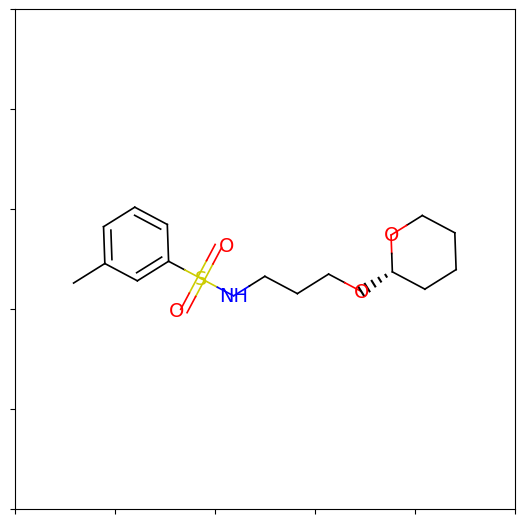

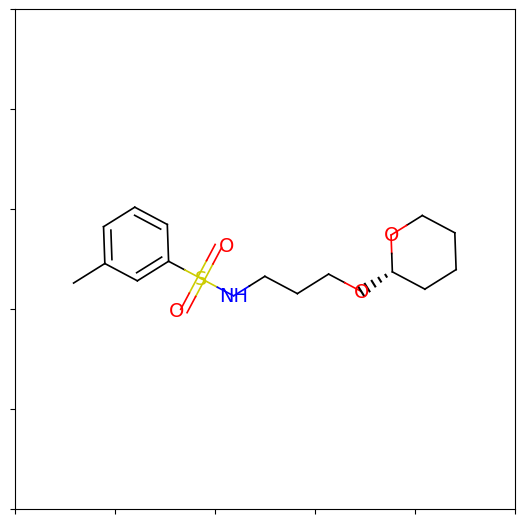

In [14]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import RDLogger

# Suppress RDKit error messages
RDLogger.DisableLog('rdApp.*')

mol = None

try:
    mol = Chem.MolFromSmiles(smiles_string)
    
except Exception as e:
    # Optionally, log any unexpected errors
    print(f"Error: {e}")
    

# Draw the valid molecule
Draw.MolToMPL(mol, size=(200,200))


In [15]:
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol

def show_molecule_3d(mol):
    mb = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=400, height=400)
    viewer.addModel(mb, format="mol")
    viewer.setStyle({'stick': {}})
    viewer.zoomTo()
    return viewer.show()
    
# Add Hydrogens to the molecule
mol = Chem.AddHs(mol)

# Generate 3D coordinates
AllChem.EmbedMolecule(mol, AllChem.ETKDG())

# Optimize the molecule using a force field (e.g., MMFF94)
AllChem.MMFFOptimizeMolecule(mol, maxIters=500, nonBondedThresh=500.0)

# Visualize
show_molecule_3d(mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [19]:
import csv

prompt = "C"
num_samples = 100000
max_new_tokens = 100
top_k = 200
temperature = 1

model.eval()
tokenizer = Tokenizer(tokenizer_path)

encoded = tokenizer.encode(prompt, bos=True, eos=False, device=device)
prompt_length = encoded.size(0)

all_smiles = []

# Create or overwrite the CSV file and write the header
with open("generated_molecules.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Molecule"])

for i in range(num_samples):
    t0 = time.perf_counter()
    y = generate(model, encoded, max_new_tokens, temperature=temperature, top_k=top_k, eos_id=tokenizer.eos_id)
    t = time.perf_counter() - t0

    model.reset_cache()
    smiles_string = tokenizer.decode(y)
    all_smiles.append(smiles_string)

    # After every 1000 molecules, write to CSV and clear the list
    if (i + 1) % 1000 == 0:
        with open("generated_molecules.csv", "a", newline='') as csvfile:
            writer = csv.writer(csvfile)
            for smiles in all_smiles:
                writer.writerow([smiles])
        all_smiles.clear()

        print(f"Generated {i + 1} molecules")
        tokens_generated = y.size(0) - prompt_length
        print(f"Time for inference {i + 1}: {t:.02f} sec total, {tokens_generated / t:.02f} tokens/sec", file=sys.stderr)

if torch.cuda.is_available():
    print(f"Memory used: {torch.cuda.max_memory_reserved() / 1e9:.02f} GB", file=sys.stderr)


Generated 50 molecules


Time for inference 50: 2.32 sec total, 12.52 tokens/sec


Generated 100 molecules


Time for inference 100: 3.19 sec total, 11.60 tokens/sec


Generated 150 molecules


Time for inference 150: 2.91 sec total, 13.39 tokens/sec


Generated 200 molecules


Time for inference 200: 3.70 sec total, 11.09 tokens/sec


Generated 250 molecules


Time for inference 250: 2.42 sec total, 12.80 tokens/sec


Generated 300 molecules


Time for inference 300: 3.18 sec total, 13.84 tokens/sec


Generated 350 molecules


Time for inference 350: 3.49 sec total, 13.19 tokens/sec


Generated 400 molecules


Time for inference 400: 2.72 sec total, 10.28 tokens/sec


Generated 450 molecules


Time for inference 450: 3.02 sec total, 11.27 tokens/sec


Generated 500 molecules


Time for inference 500: 2.60 sec total, 12.30 tokens/sec


Generated 550 molecules


Time for inference 550: 2.36 sec total, 14.84 tokens/sec


Generated 600 molecules


Time for inference 600: 1.65 sec total, 16.93 tokens/sec


Generated 650 molecules


Time for inference 650: 1.75 sec total, 18.34 tokens/sec


IndexError: Out of range: piece id is out of range.

In [20]:
with open("generated_molecules.txt", "w") as f:
    for smiles in all_smiles:
        f.write(smiles + "\n")